In [1]:
%matplotlib inline
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def initialize(Nuc, rho, T, Nbins):
    # Initializes the system to return the initial position and velocity of the particles
    
    N = 4*Nuc**3 # Total number of particles within the volume. 4 particles per FCC unit cell
    print('The number of particles is:', N)
    
    V = N/rho # Volume
    print('The volume is:', round(V, 4))
    
    L = V**(1/3) # Length of the volume in one dimension
    print('The length of the cubic volume is:', round(L, 4))
    
    Luc = L/Nuc # Length of a unit cell in one dimension
    
    binLength = L / Nbins # Binlength for the histogram of correlation function g(r)
    
    initPosition = Initial_Position(L, Luc, Nuc) # Calculate the initial positions
    initVelocity = Initial_Velocity(T, N) # Calculate the initial velocities
    
    return initPosition, initVelocity, V, N, L, Luc, binLength


def Initial_Position(L, Luc, Nuc):
    # Determines the initial positions for the Argon atoms in a FCC structure.
    
    x = np.linspace(0, L - Luc, Nuc) # Position vector to fill the space
    xx, yy, zz = np.meshgrid(x, x, x) # Square meshgrid of positions for the atoms
    Nuc3 = Nuc**3 # Total number of unit cells in volume
    
    # Reshape meshgrid into a 1D arrays
    xPos = np.reshape(xx, (Nuc3, 1))
    yPos = np.reshape(yy, (Nuc3, 1))
    zPos = np.reshape(zz, (Nuc3, 1))
    
    # Shape position vectors for the first set of particles on the square grid
    pos1 = np.hstack((xPos, yPos, zPos))
    
    # Second set of position vectors. pos1 shifted in the x, y direction
    pos2 = np.zeros((Nuc3, 3))
    pos2[:, 0] = pos1[:, 0] + Luc/2
    pos2[:, 1] = pos1[:, 1] + Luc/2
    pos2[:, 2] = pos1[:, 2]
    
    # Third set of position vectors. pos1 shifted in the y, z direction
    pos3 = np.zeros((Nuc3, 3))
    pos3[:, 0] = pos1[:, 0]
    pos3[:, 1] = pos1[:, 1] + Luc/2
    pos3[:, 2] = pos1[:, 2] + Luc/2
    
    # Fourth set of position vectors. pos1 shifted in the x, z direction
    pos4 = np.zeros((Nuc3, 3))
    pos4[:, 0] = pos1[:, 0] + Luc/2
    pos4[:, 1] = pos1[:, 1]
    pos4[:, 2] = pos1[:, 2] + Luc/2
    
    pos = np.vstack((pos1, pos2, pos3, pos4)) # Position vector of all particles
    
    return pos


def Initial_Velocity(T, N): 
    # Determine the initial velocity of the particles.  
    # Every component of the velocity is drawn from the normal distribution,
    # such that the magnitude of the velocity is Maxwell-Boltzmann distributed.
    
    mu = 0
    sigma = np.sqrt(T)
    Velocity = np.random.normal(mu, sigma, (N, 3)) # Maxwell distributed velocity
    
    meanVelocity = np.mean(Velocity, axis = 0)
    
    Velocity -= meanVelocity # Normalise the velocity so that the mean velocity is zero
    
    return Velocity

In [3]:
@jit # Compiles the following function to machine code for enhanced computation speed
def DistanceForce(pos, N, L, Nbins, binLength):
    # The function DistanceForce calculates the distance between the particles 
    # and then calculates the force between the two particles.
    # Within the for-loop the calculations are done component-wise to avoid the use of arrays. 
    # This speeds up the computation time.
    # A histogram is created for number of particles at a seperation distances between the particles.
    
    # Create empty arrays and variables
    LJForcex = np.zeros((N, 1))
    LJForcey = np.zeros((N, 1))
    LJForcez = np.zeros((N, 1))
    histogram = np.zeros(Nbins)
    LJPotential = 0
    drF = 0
    
    rCutoff2 = 1/(2.5*2.5) # cutoff distance at 2.5*sigma
    
    # Loop over the number of atom pairs
    for ii in range(N):
        for jj in range(ii+1, N):
            
            # Distance between particles in the x, y, and z direction
            deltax = pos[ii, 0] - pos[jj, 0] 
            deltay = pos[ii, 1] - pos[jj, 1]
            deltaz = pos[ii, 2] - pos[jj, 2]
            
            # Add/subtract L if image particle is closer than original. This is according to the repeated boundary condition
            deltax -= L * np.rint(deltax / L)
            deltay -= L * np.rint(deltay / L)
            deltaz -= L * np.rint(deltaz / L)
            
            # 1 over the absolute value of distance between particles, squared.
            dr2 = 1/(deltax*deltax + deltay*deltay + deltaz*deltaz)
            
            # Potential and force at cutoff range 2.5*sigma
            if dr2 > rCutoff2:
                
                LJPotential += 4*(dr2**6 - dr2**3) # Lennard-Jones potential energy within the volume
                
                # Force vector between particle ii and jj
                Fx = (48*dr2**7 - 24*dr2**4) * deltax 
                Fy = (48*dr2**7 - 24*dr2**4) * deltay
                Fz = (48*dr2**7 - 24*dr2**4) * deltaz
                
                drF += -48*dr2**6 + 24*dr2**3 # Sum the inner product of (dr . Force), i.e. the virial
                
            else:
                # The distance is big enough for the force to be neglected
                Fx = 0
                Fy = 0
                Fz = 0
            
            # Sum the forces in the force vector for the corresponding particles
            LJForcex[ii] += Fx
            LJForcex[jj] -= Fx
            
            LJForcey[ii] += Fy
            LJForcey[jj] -= Fy
            
            LJForcez[ii] += Fz
            LJForcez[jj] -= Fz
            
            #  Create histogram of the number of particles at a seperation distance
            histogram[int(1 / (np.sqrt(dr2) * binLength))] += 1
            
    LJForce = np.hstack((LJForcex, LJForcey, LJForcez)) # stack x, y, and z components to create a force vector
    
    return LJForce, LJPotential, drF, histogram

In [4]:
def Heat_Capacity(kinEnergy, N, TimeBlock, NumberOfBlocks):
    # Calculates the specific heat capacity from the variance of the kinetic energy with the Lebowitz formula.
    
    # Create empty arrays
    kinBlock = np.zeros(TimeBlock)
    Cv = np.zeros(NumberOfBlocks)
    CvPre = np.zeros(NumberOfBlocks)
    
    # Measure the Cv for each TimeBlock
    for ii in range(NumberOfBlocks):
        kinBlock = kinEnergy[ii*TimeBlock : (ii+1)*TimeBlock] # Kinetic energy within TimeBlock
        
        # Lebowitz formula. Cv in units of kB. Divide by volume to get Cv = (3/2)*(N/V) [kB]
        Cv[ii] = 1/((2/(3*N)) - (np.var(kinBlock) / (np.mean(kinBlock)**2)))
        CvPre[ii] = Cv[ii] / N # Prefactor Cv/N: should be 3/2 for a gas and 3 for a solid.
        
    MeanCv = np.mean(Cv) # Calculate the mean from all time blocks
    MeanCvPre = MeanCv/N
    
    ErrorCv = np.std(Cv)/np.sqrt(NumberOfBlocks) # Calculate the error
    ErrorCvPre = ErrorCv/N
    
    return MeanCv, MeanCvPre, ErrorCv, ErrorCvPre

In [5]:
def histogram_g(histogram, Nbins, binLength, V, N, tEquilibrium, TimeBlock, NumberOfBlocks):
    
    # Create empty arrays
    g = np.zeros((NumberOfBlocks, Nbins))
    r = np.zeros(Nbins)
    
    histogram = np.delete(histogram, np.s_[0:tEquilibrium], axis = 0) # Delete timesteps before equilibrium
    
    # Create the histogram for each TimeBlock
    for ii in range(NumberOfBlocks):
        # Average the histogram within each time block
        timeavgHistogram = np.mean(histogram[ii*TimeBlock : (ii+1)*TimeBlock, :], axis = 0) 
        
        for jj in range(Nbins):
            r[jj] = binLength * (jj + 0.5) # Calculate distance vector
            g[ii, jj] = 2*V/(N*(N-1)) * timeavgHistogram[jj] / (4*np.pi*r[jj]**2*binLength) # Correlation function g(r)
            
    meang = np.mean(g, axis = 0) # Calculate the mean from all time blocks
    errorg = np.std(g, axis = 0) / np.sqrt(NumberOfBlocks) # Calculate the error
    
    return meang, errorg, r

In [6]:
def Calculate_Pressure(drF, actualT, N, L, TimeBlock, NumberOfBlocks):
    
    Pressure = np.zeros(NumberOfBlocks) # Create empty array
    
    # Measure the pressure for each TimeBlock
    for ii in range(NumberOfBlocks):
        # Pressure calculation, corrected for the cutoff potential
        Pressure[ii] = np.average(1.0 - drF[ii*TimeBlock : (ii+1)*TimeBlock] / (3*N*actualT[ii*TimeBlock : (ii+1)*TimeBlock]) 
                               - 2*np.pi*N/(3*actualT[ii*TimeBlock : (ii+1)*TimeBlock]*L**3) * 0.5106)
    
    meanPressure = np.mean(Pressure) # Calculate the mean from all timeblocks
    
    errorPressure = np.std(Pressure) / np.sqrt(NumberOfBlocks) # Calculate the error
    
    return meanPressure, errorPressure

In [7]:
def simulate(V, N, L, T, tEquilibrium, pos, vel, n_t, dt, Nbins, binLength, TimeBlock):
    # Runs the simulation by propagating the particles.
    # Extracts parameters from the simulation and prints the results.
    # Function returns all valuable variables of the simulation
    
    Force, Potential, drF, n = DistanceForce(pos, N, L, Nbins, binLength) # Force Potential and dr.F from initial positions
    
    # Create empty arrays
    kinEnergy = np.zeros(n_t)
    potEnergy = np.zeros(n_t)
    Pressure = np.zeros(n_t)
    drF = np.zeros(n_t)
    histogram = np.zeros((n_t, Nbins))
    
    print('\nsimulation is running\n')
    
    # Discrete time evolution of the particles
    for ii in range(n_t):
        # Move the particle according to the Verlet algorithm
        vel += 0.5 * Force * dt
        pos += vel * dt
        pos = pos % L # apply repeated boundary conditions
        
        # Calculate the new force of the particles, potential energy, the virial 'drF', and histogram.
        Force, potEnergy[ii], drF[ii], histogram[ii,:] = DistanceForce(pos, N, L, Nbins, binLength)
        
        vel += 0.5 * Force * dt
        
        kinEnergy[ii] = 0.5 * np.sum(vel * vel) # Kinetc energy for this timestep
        
        # Adjust velocity to acquire a constant temperature TDesired.
        # After tEquilibrium system should be in equilibrium with a somewhat constant T
        if ii < tEquilibrium and (ii % 10 == 0):
            vel = vel * np.sqrt((N-1)*3*T / (2*kinEnergy[ii]))
    
    actualT = 2/(3*N)*kinEnergy # Actual temperature during the simulation
    
    
    # Calculate several parameters from the simulation
    # The total measured time 'n_t' is devided by 'TimeBlock' into 'NumberOfBlocks' individual measurements
    NumberOfBlocks = int((n_t - tEquilibrium)/TimeBlock) # Calculate the number of measurement intervals in total time
    
    # Calculate the heat capacity Cv and its prefactor Cv/N with the corresponding errors
    Cv, CvPre, errorCv, errorCvPre = Heat_Capacity(kinEnergy[tEquilibrium:], N, TimeBlock, NumberOfBlocks)
    
    # Calculate the correlation function g(r) and the error
    g, errorg, r = histogram_g(histogram, Nbins, binLength, V, N, tEquilibrium, TimeBlock, NumberOfBlocks)
    
    # Calculate the pressure in the volume.
    Pressure, errorPressure = Calculate_Pressure(drF, actualT, N, L, TimeBlock, NumberOfBlocks)
    
    print('The number of measurements is: ', NumberOfBlocks, '\n')
    
    print('Heat Capacity: ',  round(Cv, 4), '+-',  round(errorCv, 4))
    print('Prefactor: ',  round(CvPre, 4), '+-', round(errorCvPre, 4))
    print('Pressure: ',  round(Pressure, 4), '+-', round(errorPressure, 4))
    print('Average Temperature: ',  round( np.average(actualT[tEquilibrium:]), 4))
    
    return pos, vel, potEnergy, kinEnergy, g, errorg, r, Cv, CvPre, errorCv, errorCvPre, Pressure, errorPressure

In [9]:
# Simulation of argon atoms in a volume V with length L. 
rho = 0.80 # Density  [kg/m3]
T = 1.462 # Temperature [120*K]. Temperature will be regulated until system is in equillibrium [120*K]
Nuc = 3 # Number of unit cells in one dimension. For actual measurements Nuc = 6 is advised

dt = 0.004 # Time step of the simulation
n_t = 5500 # Total amount of time steps. For an actual measurement n_t = 15500 is advised.
tEquilibrium = 500 # Time steps after which the temperature is constant. Condition: tEquilibrium < n_t
TimeBlock = 1000 # Time interval over which one measurement is performed

Nbins = 300 # Number of bins in histogram for the correlation function g(r)

# Define the position and velocity at t = 0
pos, vel, V, N, L, Luc, binLength = initialize(Nuc, rho, T, Nbins)

# Run the simulation for the argon atoms
posNew, velNew, potEnergy, kinEnergy, g, errorg, r, Cv, CvPre, errorCv, errorCvPre, Pressure, errorPressure = simulate(V, N, L, T, tEquilibrium, pos, vel, n_t, dt, Nbins, binLength, TimeBlock)


The number of particles is: 108
The volume is: 135.0
The length of the cubic volume is: 5.1299

simulation is running

The number of measurements is:  5 

Heat Capacity:  235.9532 +- 6.709
Prefactor:  2.1848 +- 0.0621
Pressure:  2.7329 +- 0.0553
Average Temperature:  1.5197


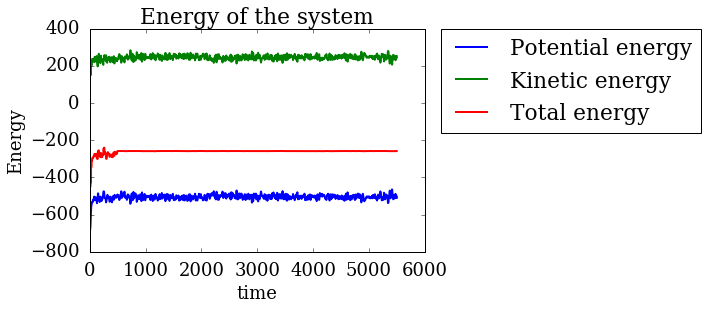

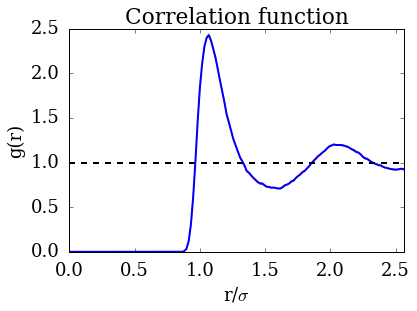

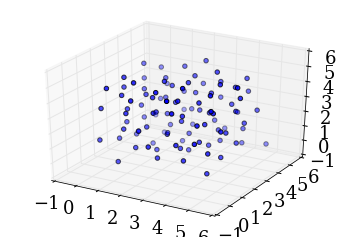

In [14]:
font = {'family' : 'serif',
        'size'   : 18}

plt.rc('font', **font)

# Plot the energy of the system
t = np.linspace(1, n_t, n_t)
plt.figure()
plt.plot(t, potEnergy, label = 'Potential energy', linewidth = 2)
plt.plot(t, kinEnergy, label = 'Kinetic energy', linewidth = 2)
plt.plot(t, kinEnergy + potEnergy, label = 'Total energy', linewidth = 2)
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.ylabel('Energy')
plt.xlabel('time')
plt.title('Energy of the system')
plt.tick_params(axis = 'both', pad=10)


# Plot the correlation function g(r)
plt.figure()
plt.plot(r, g, linewidth = 2)
plt.axhline(y = 1, color = 'k', linestyle = 'dashed', linewidth = 2)
plt.fill_between(r, g-errorg, g+errorg, alpha = 0.5, edgecolor = '#CC4F1B', facecolor = '#FF9848')
plt.ylabel('g(r)')
plt.xlabel('r/$\sigma$')
plt.title('Correlation function')
plt.xlim(0, 0.5*L)
plt.tick_params(axis = 'both', pad = 10)


# Plot the end positions of the particles
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(posNew[:, 0], posNew[:, 1], posNew[:, 2], marker = 'o')


plt.show()

In [16]:
# Simulation of argon in a volume V with length L. 
# This version of the simulation allows for a sweep along multiple densities at a fixed temperature.

dt = 0.004 # Time step of the simulation
n_t = 5500 # Total amount of time steps 
tEquilibrium = 500 # Time steps after which the temperature is constant. Condition: tEquilibrium < n_t
TimeBlock = 1000 # time interval over which one measurement is performed

Nbins = 10 # number of bins in histogram for the correlation function g(r)

T = 1.36 # Temperature. Epsilon/k_b [120*K]
rho_step = np.linspace(0.10, 0.80, 8) # Density  [kg/m3]
Nuc = 3 # Number of unit cells in one dimension. For an actual measurement Nuc = 4 or higher is advised


Cv = np.zeros(len(rho_step))
CvPre = np.zeros(len(rho_step))
ErrorCv = np.zeros(len(rho_step))
ErrorCvPre = np.zeros(len(rho_step))
Pressure = np.zeros(len(rho_step))
errorPressure = np.zeros(len(rho_step))

for ii in range(len(rho_step)):
    # Define the position and velocity at t = 0
    pos, vel, V, N, L, Luc, binLength = initialize(Nuc, rho_step[ii], T, Nbins)
    
    print('density: ', rho_step[ii])
    
    # Run the simulation for different rho
    posNew, velNew, potEnergy, kinEnergy, g, errorg, r, Cv[ii], CvPre[ii], ErrorCv[ii], ErrorCvPre[ii], Pressure[ii], errorPressure[ii] = simulate(V, N, L, T, tEquilibrium, pos, vel, n_t, dt, Nbins, binLength, TimeBlock)
    


The number of particles is: 108
The volume is: 1080.0
The length of the cubic volume is: 10.2599
density:  0.1

simulation is running

The number of measurements is:  5 

Heat Capacity:  179.047 +- 1.6946
Prefactor:  1.6578 +- 0.0157
Pressure:  0.7478 +- 0.0101
Average Temperature:  1.3627
The number of particles is: 108
The volume is: 540.0
The length of the cubic volume is: 8.1433
density:  0.2

simulation is running

The number of measurements is:  5 

Heat Capacity:  187.225 +- 3.7124
Prefactor:  1.7336 +- 0.0344
Pressure:  0.5909 +- 0.0151
Average Temperature:  1.4417
The number of particles is: 108
The volume is: 360.0
The length of the cubic volume is: 7.1138
density:  0.3

simulation is running

The number of measurements is:  5 

Heat Capacity:  194.9315 +- 3.1267
Prefactor:  1.8049 +- 0.029
Pressure:  0.3112 +- 0.0227
Average Temperature:  1.3126
The number of particles is: 108
The volume is: 270.0
The length of the cubic volume is: 6.4633
density:  0.4

simulation is running

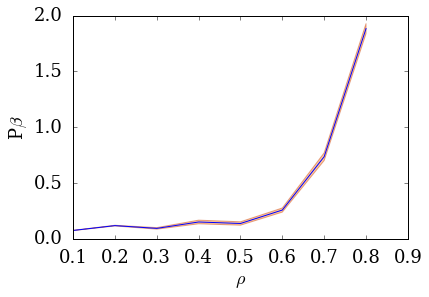

In [17]:
# Plot P*beta as a function of rho for an isotherm

font = {'family' : 'serif',
       'size'   : 18}

plt.rc('font', **font)

plt.figure()
plt.plot(rho_step, Pressure*rho_step)
plt.fill_between(rho_step, rho_step*(Pressure-errorPressure), rho_step*(Pressure+errorPressure), alpha = 0.5, edgecolor = '#CC4F1B', facecolor = '#FF9848')
plt.ylabel(r'P$\beta$')
plt.xlabel(r'$\rho$')
plt.ylim(0, 2)
plt.tick_params(axis = 'both', pad = 10)
